# 1.Prepare data


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !cp /content/drive/MyDrive/kaggle.json /content/

In [ ]:
!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c plant-seedlings-classification

100% 1.68G/1.69G [00:15<00:00, 117MB/s]
100% 1.69G/1.69G [00:15<00:00, 117MB/s]


In [ ]:
!unzip /content/plant-seedlings-classification.zip


流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: test/ad12382d4.png      
  inflating: test/adb7a032c.png      
  inflating: test/ae90f2827.png      
  inflating: test/aecfaed64.png      
  inflating: test/aee6fa3df.png      
  inflating: test/af45e222a.png      
  inflating: test/afa446484.png      
  inflating: test/afcf6abd5.png      
  inflating: test/b026bf8ca.png      
  inflating: test/b03397525.png      
  inflating: test/b0acaff4a.png      
  inflating: test/b130a0632.png      
  inflating: test/b145ba9d4.png      
  inflating: test/b1cd2a91e.png      
  inflating: test/b215531dd.png      
  inflating: test/b2706e2b3.png      
  inflating: test/b29339405.png      
  inflating: test/b30ab4659.png      
  inflating: test/b31292706.png      
  inflating: test/b341d0aab.png      
  inflating: test/b39c71707.png      
  inflating: test/b3d6fdb80.png      
  inflating: test/b3e08b037.png      
  inflating: test/b47691c08.png      
  inflating: test/b4c3df835.png      
  inflating: test/b4f7c

# 2.Import python package

In [ ]:
import pandas as pd
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import math
import skimage
import seaborn as sns
from sklearn import metrics


import matplotlib.pyplot as plt

import os
import PIL


import torch
from torch.utils.data import Dataset
from torchvision import datasets,models
from torchvision.transforms import ToTensor
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F

# 3.Hyperparameter definition

In [ ]:
img_height = 224
img_width = 224
batch_size = 8

# 4.Data processing pipeline

## Generate dataset

In [ ]:
img_dir = '/content/train'

In [ ]:
train_transform = transforms.Compose([
                    transforms.RandomRotation(5),
                    transforms.RandomHorizontalFlip(),
                    transforms.Resize((224,224)),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])

In [ ]:
image_datasets = datasets.ImageFolder(img_dir,train_transform)
image_datasets

Dataset ImageFolder
    Number of datapoints: 4750
    Root location: /content/train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-5.0, 5.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
image_datasets.classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [ ]:
num_classes = len(image_datasets.classes)
num_classes

12

In [ ]:
len(image_datasets)

4750

In [ ]:

train_set, val_set = torch.utils.data.random_split(image_datasets, [4000, 750])

len(train_set),len(val_set)

(4000, 750)

In [ ]:
len(image_datasets),len(train_set),len(val_set)

(4750, 4000, 750)

In [ ]:
image_datasets[0][0].shape, image_datasets[0][1]

(torch.Size([3, 224, 224]), 0)

## Generate dataloader

In [ ]:
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True,num_workers=2)
test_dataloader = DataLoader(val_set, batch_size=8, shuffle=False,num_workers=2)

In [ ]:
# Display image and label.
b_img_rgb, train_labels = next(iter(train_dataloader))
print(f"b_img_rgb batch shape: {b_img_rgb.size()}")
print(f"train_labels batch shape: {train_labels.size()}")


b_img_rgb batch shape: torch.Size([8, 3, 224, 224])
train_labels batch shape: torch.Size([8])


## Visualization sample

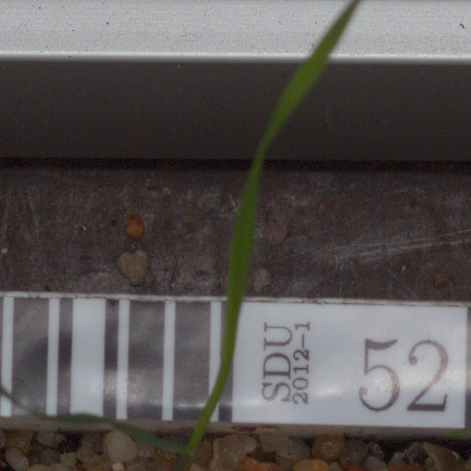

In [ ]:
from PIL import Image

Image.open('/content/train/Black-grass/075d004bc.png')



In [ ]:
train_labels

tensor([ 3,  5,  6, 10, 10,  6,  4,  2])

# 5.Determine CPU GPU device

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


Using cuda device


# 6.Training and evaluation loop

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (img_rgb, y) in enumerate(dataloader):
        # X, y = X.to(device), y.to(device)
        img_rgb = img_rgb.to(device)

        y = y.to(device)

        # Compute prediction error
        pred = model(img_rgb)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(img_rgb)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for (img_rgb, y) in dataloader:
            img_rgb = img_rgb.to(device)

            y = y.to(device)

            pred = model(img_rgb)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

# 7.Model CNN

## Build a basic model

In [ ]:
class BaseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.conv4 = nn.Conv2d(32, 32, 3)
        self.fc1 = nn.Linear(4608, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


cnn_model = BaseModel().to(device)

cnn_model(b_img_rgb.to(device)).shape

torch.Size([8, 12])

## Assignment loss function and optimizer

In [ ]:
## Quickly identify an optimizer (Adam or SGD) for preliminary experiments

In [ ]:
score_data = []

# Assuming 'model' is the CNN model you have defined earlier
for opt, opt_name in zip([torch.optim.Adam, torch.optim.SGD], ['Adam', 'SGD']):
    for lr in [0.001]:
        # Resetting the model for each experiment
        Base_model = BaseModel().to(device)  # Assuming 'CNN' is the name of your CNN class
        optimizer = opt(Base_model.parameters(), lr=lr)

        epochs = 3
        for t in range(epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            # Train and validate your model
            train(train_dataloader, Base_model, loss_fn, optimizer)
            test(train_dataloader, Base_model, loss_fn)
            test(test_dataloader, Base_model, loss_fn)

        print("Done!")

        # Evaluation code remains the same
        predict_list = []
        label_list = []
        predict_pro_list = []
        m_softmax = nn.Softmax(dim=1)
        for (img_rgb, y) in test_dataloader:
            img_rgb = img_rgb.to(device)
            y = y.to(device)

            predict_score = Base_model(img_rgb)
            predict_pro = m_softmax(predict_score)

            predict_label = np.argmax(predict_score.detach().cpu().numpy(), axis=1)

            predict_pro_list.append(predict_pro.detach().cpu().numpy())
            predict_list.append(predict_label)
            label_list.append(y.detach().cpu().numpy())

        predict_pro_array = np.vstack(predict_pro_list)[:, 1]
        predict_array = np.hstack(predict_list)
        label_array = np.hstack(label_list)

        acc = np.mean(predict_array == label_array)
        score_data.append([opt_name, lr, acc])

# Converting score_data to a pandas DataFrame for visualization
import pandas as pd
df = pd.DataFrame(score_data, columns=['Optimizer', 'Learning Rate', 'Accuracy'])
df


####Model cnn preliminary experiment determined Adam

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-3)

## Training and evaluation

In [ ]:
epochs = 10
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, cnn_model, loss_fn, optimizer)

    train_loss, train_correct = test(train_dataloader, cnn_model, loss_fn)
    test_loss, test_correct = test(test_dataloader, cnn_model, loss_fn)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_correct)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_correct)
print("Done!")

Epoch 1
-------------------------------
loss: 2.490593  [    0/ 4000]
loss: 2.175465  [  400/ 4000]
loss: 2.371401  [  800/ 4000]
loss: 2.372134  [ 1200/ 4000]
loss: 2.413133  [ 1600/ 4000]
loss: 2.344782  [ 2000/ 4000]
loss: 2.484731  [ 2400/ 4000]
loss: 2.293208  [ 2800/ 4000]
loss: 2.112109  [ 3200/ 4000]
loss: 2.333395  [ 3600/ 4000]
Test Error: 
 Accuracy: 14.0%, Avg loss: 2.285870 

Test Error: 
 Accuracy: 12.3%, Avg loss: 2.261713 

Epoch 2
-------------------------------
loss: 2.403484  [    0/ 4000]
loss: 2.269691  [  400/ 4000]
loss: 2.069308  [  800/ 4000]
loss: 2.051949  [ 1200/ 4000]
loss: 1.977503  [ 1600/ 4000]
loss: 2.005223  [ 2000/ 4000]
loss: 1.733891  [ 2400/ 4000]
loss: 1.663602  [ 2800/ 4000]
loss: 1.749155  [ 3200/ 4000]
loss: 1.978287  [ 3600/ 4000]
Test Error: 
 Accuracy: 42.6%, Avg loss: 1.594292 

Test Error: 
 Accuracy: 42.9%, Avg loss: 1.584023 

Epoch 3
-------------------------------
loss: 1.710448  [    0/ 4000]
loss: 2.225960  [  400/ 4000]
loss: 1.9783

## Visualize the training process

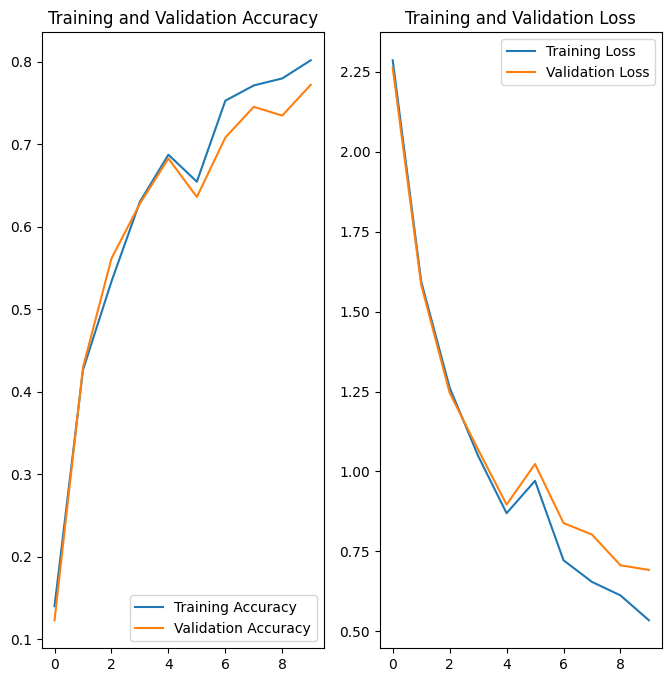

In [ ]:
# train_loss_array,train_acc_array,val_loss_array,val_acc_array
acc = train_acc_list
val_acc = test_acc_list

loss = train_loss_list
val_loss = test_loss_list
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model validation set prediction

In [ ]:
predict_list = []
label_list = []
predict_pro_list = []
m_softmax = nn.Softmax(dim=1)
for (img_rgb, y) in test_dataloader:
    img_rgb = img_rgb.to(device)
    y = y.to(device)

    predict_score = cnn_model(img_rgb)
    predict_pro = m_softmax(predict_score)

    predict_label = np.argmax(predict_score.detach().cpu().numpy(),axis=1)

    predict_pro_list.append(predict_pro.detach().cpu().numpy())
    predict_list.append(predict_label)
    label_list.append(y.detach().cpu().numpy())

predict_pro_array = np.vstack(predict_pro_list)[:,1]
predict_array = np.hstack(predict_list)
label_array = np.hstack(label_list)
predict_pro_array[:5],predict_array[:5],label_array[:5]

(array([7.8274361e-06, 1.7325129e-06, 1.9068051e-05, 7.6200517e-06,
        1.7277176e-05], dtype=float32),
 array([ 3, 10,  3, 11,  4]),
 array([ 3, 10,  3, 10,  0]))

### Classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(label_array, predict_array,digits=3))

              precision    recall  f1-score   support

           0      0.000     0.000     0.000        38
           1      0.833     0.750     0.789        60
           2      0.820     0.872     0.845        47
           3      0.823     0.869     0.845       107
           4      0.838     0.939     0.886        33
           5      0.816     0.775     0.795        80
           6      0.690     0.935     0.794       107
           7      0.697     0.742     0.719        31
           8      0.778     0.645     0.705        76
           9      0.708     0.586     0.642        29
          10      0.925     0.822     0.871        90
          11      0.529     0.712     0.607        52

    accuracy                          0.763       750
   macro avg      0.705     0.721     0.708       750
weighted avg      0.740     0.763     0.746       750



### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(label_array, predict_array)
cnf_matrix

array([[  0,   0,   0,   0,   2,   0,  35,   0,   0,   0,   0,   1],
       [  0,  45,   5,   0,   1,   4,   0,   2,   2,   0,   1,   0],
       [  0,   4,  41,   0,   0,   0,   0,   0,   0,   0,   1,   1],
       [  0,   0,   0,  93,   0,   0,   1,   4,   1,   1,   0,   7],
       [  0,   0,   0,   0,  31,   0,   2,   0,   0,   0,   0,   0],
       [  0,   0,   1,   2,   0,  62,   4,   0,   2,   0,   0,   9],
       [  1,   0,   0,   0,   2,   2, 100,   0,   1,   0,   1,   0],
       [  0,   1,   0,   2,   0,   0,   0,  23,   1,   1,   1,   2],
       [  3,   3,   3,   8,   0,   1,   3,   1,  49,   5,   0,   0],
       [  0,   0,   0,   5,   0,   1,   0,   0,   2,  17,   2,   2],
       [  0,   1,   0,   1,   0,   0,   0,   2,   1,   0,  74,  11],
       [  1,   0,   0,   2,   1,   6,   0,   1,   4,   0,   0,  37]])

<Axes: >

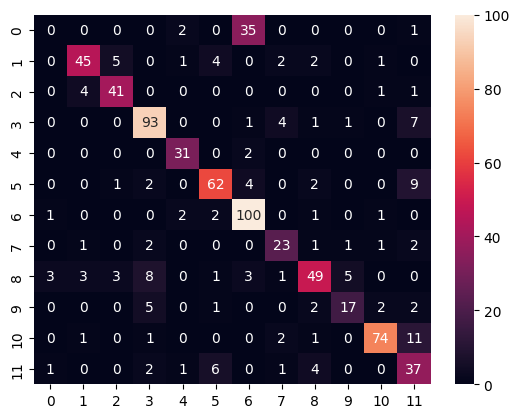

In [ ]:
sns.heatmap(cnf_matrix, annot=True, fmt='g')

# 8.Model resnet18

## Build a basic model

In [ ]:

base_model_resnet18 = models.resnet18(pretrained=True)
num_ftrs = base_model_resnet18.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
base_model_resnet18.fc = nn.Linear(num_ftrs, num_classes)

base_model_resnet18 = base_model_resnet18.to(device)

base_model_resnet18(b_img_rgb.to(device)).shape

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([8, 12])

In [ ]:
base_model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Assignment loss function and optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(base_model_resnet18.parameters(), lr=1e-3)

## Training and evaluation

In [ ]:
epochs = 10
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, base_model_resnet18, loss_fn, optimizer)

    train_loss, train_correct = test(train_dataloader, base_model_resnet18, loss_fn)
    test_loss, test_correct = test(test_dataloader, base_model_resnet18, loss_fn)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_correct)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_correct)
print("Done!")

Epoch 1
-------------------------------
loss: 1.683925  [    0/ 4000]
loss: 2.574922  [  400/ 4000]
loss: 1.930646  [  800/ 4000]
loss: 2.164026  [ 1200/ 4000]
loss: 2.025184  [ 1600/ 4000]
loss: 2.042659  [ 2000/ 4000]
loss: 2.145913  [ 2400/ 4000]
loss: 2.817843  [ 2800/ 4000]
loss: 3.036576  [ 3200/ 4000]
loss: 1.563075  [ 3600/ 4000]
Test Error: 
 Accuracy: 42.0%, Avg loss: 1.792418 

Test Error: 
 Accuracy: 42.4%, Avg loss: 1.722479 

Epoch 2
-------------------------------
loss: 2.219195  [    0/ 4000]
loss: 2.637635  [  400/ 4000]
loss: 1.545162  [  800/ 4000]
loss: 1.445683  [ 1200/ 4000]
loss: 1.126789  [ 1600/ 4000]
loss: 1.902915  [ 2000/ 4000]
loss: 1.841252  [ 2400/ 4000]
loss: 1.021259  [ 2800/ 4000]
loss: 1.036043  [ 3200/ 4000]
loss: 0.877666  [ 3600/ 4000]
Test Error: 
 Accuracy: 50.9%, Avg loss: 1.402120 

Test Error: 
 Accuracy: 51.6%, Avg loss: 1.373305 

Epoch 3
-------------------------------
loss: 1.324279  [    0/ 4000]
loss: 1.076637  [  400/ 4000]
loss: 1.6827

## Visualize the training process

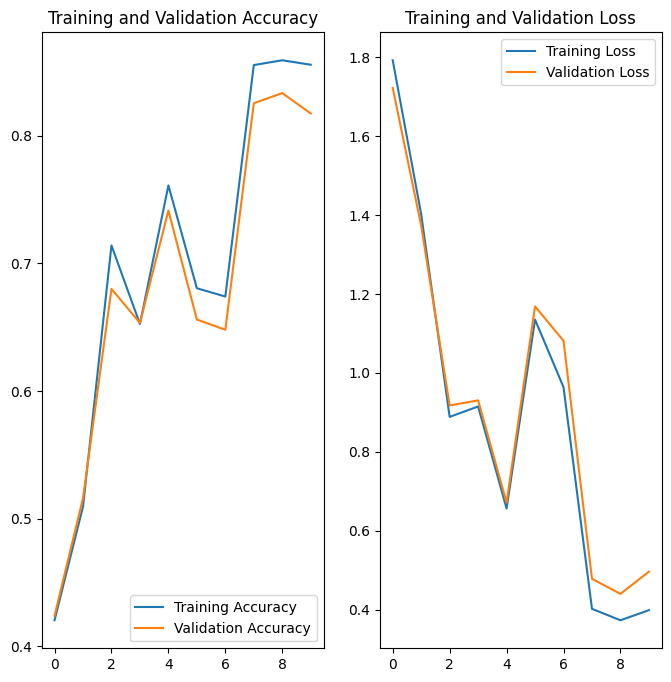

In [ ]:
# train_loss_array,train_acc_array,val_loss_array,val_acc_array
acc = train_acc_list
val_acc = test_acc_list

loss = train_loss_list
val_loss = test_loss_list
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model validation set prediction

In [ ]:
predict_list = []
label_list = []
predict_pro_list = []
m_softmax = nn.Softmax(dim=1)
for (img_rgb, y) in test_dataloader:
    img_rgb = img_rgb.to(device)
    y = y.to(device)

    predict_score = base_model_resnet18(img_rgb)
    predict_pro = m_softmax(predict_score)

    predict_label = np.argmax(predict_score.detach().cpu().numpy(),axis=1)

    predict_pro_list.append(predict_pro.detach().cpu().numpy())
    predict_list.append(predict_label)
    label_list.append(y.detach().cpu().numpy())

predict_pro_array = np.vstack(predict_pro_list)[:,1]
predict_array = np.hstack(predict_list)
label_array = np.hstack(label_list)
predict_pro_array[:5],predict_array[:5],label_array[:5]

(array([7.1692943e-06, 8.6001050e-01, 3.1693603e-06, 4.5091647e-07,
        1.3371392e-02], dtype=float32),
 array([4, 1, 3, 3, 2]),
 array([4, 1, 3, 3, 2]))

### Classification report

from sklearn.metrics import classification_report
print(classification_report(label_array, predict_array,digits=3))

### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(label_array, predict_array)
cnf_matrix

array([[  0,   0,   0,   0,   9,   0,  39,   0,   2,   0,   0,   1],
       [  0,  57,  14,   0,   0,   0,   0,   0,   0,   0,   0,   1],
       [  0,   2,  40,   0,   0,   0,   0,   1,   0,   0,   0,   0],
       [  0,   0,   0,  89,   0,   0,   1,   4,   1,   1,   0,   0],
       [  0,   0,   1,   0,  21,   0,   0,   0,   0,   0,   0,   0],
       [  0,   1,   4,   0,   4,  65,   1,   0,   0,   0,   0,   0],
       [  0,   0,   0,   1,   3,   0, 108,   0,   3,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  30,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  75,   0,   0,   0],
       [  0,   1,   0,   3,   0,   2,   0,   0,  13,  15,   0,   0],
       [  0,   1,   0,   0,   0,   0,   0,   0,   0,   0,  69,   0],
       [  0,   0,   1,   0,   4,   3,   0,  10,   0,   0,   0,  49]])

<Axes: >

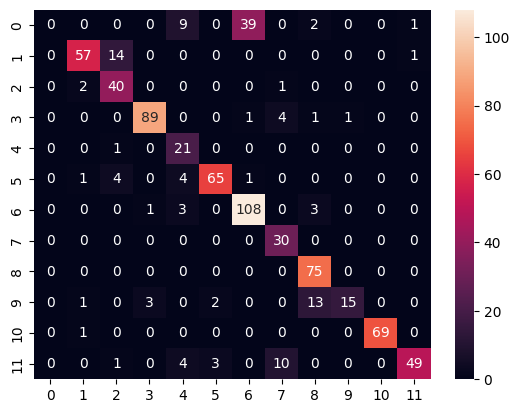

In [ ]:
sns.heatmap(cnf_matrix, annot=True, fmt='g')

# 9.Model swin_transformer

## Build basic model

In [ ]:

base_model_swin = models.swin_b(pretrained=True)

base_model_swin.head = nn.Linear(1024, num_classes)

base_model_swin.to(device)(b_img_rgb.to(device)).shape

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Swin_B_Weights.IMAGENET1K_V1`. You can also use `weights=Swin_B_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([8, 12])

In [ ]:
base_model_swin

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention(
          (qkv): Linear(in_features=128, out_features=384, bias=True)
          (proj): Linear(in_features=128, out_features=128, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=512, out_features=128, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): SwinTransformerBlock

## Assign loss function and optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(base_model_swin.parameters(), lr=1e-3)


## Training and evaluation

In [ ]:
epochs = 10
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, base_model_swin, loss_fn, optimizer)

    train_loss, train_correct = test(train_dataloader, base_model_swin, loss_fn)
    test_loss, test_correct = test(test_dataloader, base_model_swin, loss_fn)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_correct)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_correct)

print("Done!")

Epoch 1
-------------------------------
loss: 1.143461  [    0/ 4000]
loss: 1.135431  [  400/ 4000]
loss: 0.848754  [  800/ 4000]
loss: 1.021006  [ 1200/ 4000]
loss: 1.117684  [ 1600/ 4000]
loss: 1.200961  [ 2000/ 4000]
loss: 1.179006  [ 2400/ 4000]
loss: 1.289839  [ 2800/ 4000]
loss: 1.435091  [ 3200/ 4000]
loss: 1.044961  [ 3600/ 4000]
Test Error: 
 Accuracy: 72.9%, Avg loss: 0.838770 

Test Error: 
 Accuracy: 73.6%, Avg loss: 0.809580 

Epoch 2
-------------------------------
loss: 1.098336  [    0/ 4000]
loss: 1.313013  [  400/ 4000]
loss: 0.799791  [  800/ 4000]
loss: 0.874804  [ 1200/ 4000]
loss: 1.284380  [ 1600/ 4000]
loss: 0.619938  [ 2000/ 4000]
loss: 1.000411  [ 2400/ 4000]
loss: 0.997788  [ 2800/ 4000]
loss: 0.971213  [ 3200/ 4000]
loss: 0.756444  [ 3600/ 4000]
Test Error: 
 Accuracy: 73.6%, Avg loss: 0.752348 

Test Error: 
 Accuracy: 76.0%, Avg loss: 0.725258 

Epoch 3
-------------------------------
loss: 1.195571  [    0/ 4000]
loss: 0.921373  [  400/ 4000]
loss: 1.1490

## Visualize the training process

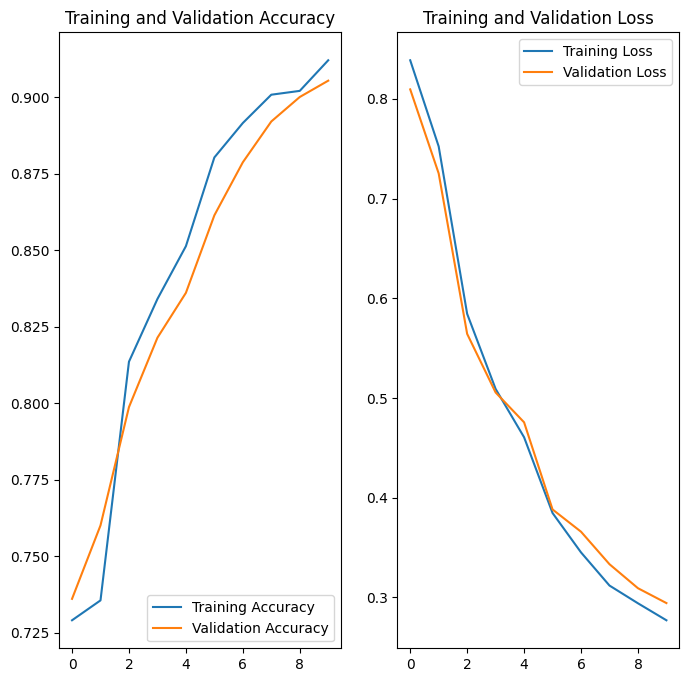

In [ ]:
# train_loss_array,train_acc_array,val_loss_array,val_acc_array
acc = train_acc_list
val_acc = test_acc_list

loss = train_loss_list
val_loss = test_loss_list
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model validation set prediction

In [ ]:
predict_list = []
label_list = []
predict_pro_list = []
m_softmax = nn.Softmax(dim=1)
for (img_rgb, y) in test_dataloader:
    img_rgb = img_rgb.to(device)
    y = y.to(device)

    predict_score = base_model_swin(img_rgb)
    predict_pro = m_softmax(predict_score)

    predict_label = np.argmax(predict_score.detach().cpu().numpy(),axis=1)

    predict_pro_list.append(predict_pro.detach().cpu().numpy())
    predict_list.append(predict_label)
    label_list.append(y.detach().cpu().numpy())

predict_pro_array = np.vstack(predict_pro_list)[:,1]
predict_array = np.hstack(predict_list)
label_array = np.hstack(label_list)
predict_pro_array[:5],predict_array[:5],label_array[:5]

(array([1.6786172e-03, 9.3288600e-01, 1.1288078e-04, 2.9275666e-06,
        4.5214905e-03], dtype=float32),
 array([0, 1, 3, 3, 2]),
 array([4, 1, 3, 3, 2]))

### Classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(label_array, predict_array,digits=3))

              precision    recall  f1-score   support

           0      0.750     0.353     0.480        51
           1      0.972     0.958     0.965        72
           2      0.953     0.953     0.953        43
           3      0.949     0.969     0.959        96
           4      0.800     0.727     0.762        22
           5      0.896     0.920     0.908        75
           6      0.787     0.965     0.867       115
           7      1.000     0.900     0.947        30
           8      0.877     0.947     0.910        75
           9      0.821     0.676     0.742        34
          10      0.986     1.000     0.993        70
          11      0.928     0.955     0.941        67

    accuracy                          0.896       750
   macro avg      0.893     0.860     0.869       750
weighted avg      0.894     0.896     0.888       750



### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(label_array, predict_array)
cnf_matrix

array([[ 18,   0,   0,   0,   2,   0,  30,   0,   0,   0,   0,   1],
       [  0,  69,   1,   0,   0,   1,   0,   0,   1,   0,   0,   0],
       [  0,   0,  41,   0,   0,   1,   0,   0,   0,   1,   0,   0],
       [  0,   0,   0,  93,   0,   0,   0,   0,   1,   2,   0,   0],
       [  3,   0,   0,   0,  16,   2,   0,   0,   1,   0,   0,   0],
       [  0,   2,   0,   0,   2,  69,   0,   0,   0,   0,   0,   2],
       [  3,   0,   0,   0,   0,   1, 111,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   1,   0,  27,   0,   0,   0,   2],
       [  0,   0,   0,   2,   0,   0,   0,   0,  71,   2,   0,   0],
       [  0,   0,   1,   3,   0,   0,   0,   0,   6,  23,   1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  70,   0],
       [  0,   0,   0,   0,   0,   2,   0,   0,   1,   0,   0,  64]])

<Axes: >

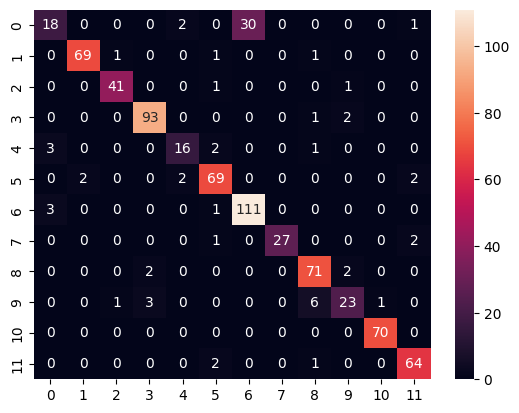

In [ ]:
sns.heatmap(cnf_matrix, annot=True, fmt='g')

# 10.Model vgg13

## Build basic model

In [ ]:

base_model_vgg13 = models.vgg13(pretrained=True)

base_model_vgg13.classifier[-1] = nn.Linear(4096, num_classes)

base_model_vgg13.to(device)(b_img_rgb.to(device)).shape

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG13_Weights.IMAGENET1K_V1`. You can also use `weights=VGG13_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([8, 12])

In [ ]:
base_model_vgg13

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): 

## Assign loss function and optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(base_model_vgg13.parameters(), lr=1e-3)

## Training and evaluation

In [ ]:
epochs = 10
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, base_model_vgg13, loss_fn, optimizer)

    train_loss, train_correct = test(train_dataloader, base_model_vgg13, loss_fn)
    test_loss, test_correct = test(test_dataloader, base_model_vgg13, loss_fn)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_correct)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_correct)

print("Done!")

Epoch 1
-------------------------------
loss: 2.673604  [    0/ 4000]
loss: 2.440457  [  400/ 4000]
loss: 2.376255  [  800/ 4000]
loss: 2.356610  [ 1200/ 4000]
loss: 2.620841  [ 1600/ 4000]
loss: 2.189845  [ 2000/ 4000]
loss: 2.462212  [ 2400/ 4000]
loss: 2.436990  [ 2800/ 4000]
loss: 2.428798  [ 3200/ 4000]
loss: 2.353286  [ 3600/ 4000]
Test Error: 
 Accuracy: 32.0%, Avg loss: 2.263100 

Test Error: 
 Accuracy: 34.9%, Avg loss: 2.249590 

Epoch 2
-------------------------------
loss: 2.317627  [    0/ 4000]
loss: 2.472754  [  400/ 4000]
loss: 2.107623  [  800/ 4000]
loss: 2.013870  [ 1200/ 4000]
loss: 1.909593  [ 1600/ 4000]
loss: 2.100121  [ 2000/ 4000]
loss: 1.706661  [ 2400/ 4000]
loss: 1.954773  [ 2800/ 4000]
loss: 1.888551  [ 3200/ 4000]
loss: 2.092734  [ 3600/ 4000]
Test Error: 
 Accuracy: 43.8%, Avg loss: 1.897349 

Test Error: 
 Accuracy: 46.3%, Avg loss: 1.863502 

Epoch 3
-------------------------------
loss: 2.112382  [    0/ 4000]
loss: 1.718036  [  400/ 4000]
loss: 1.9364

## Visualize the training process

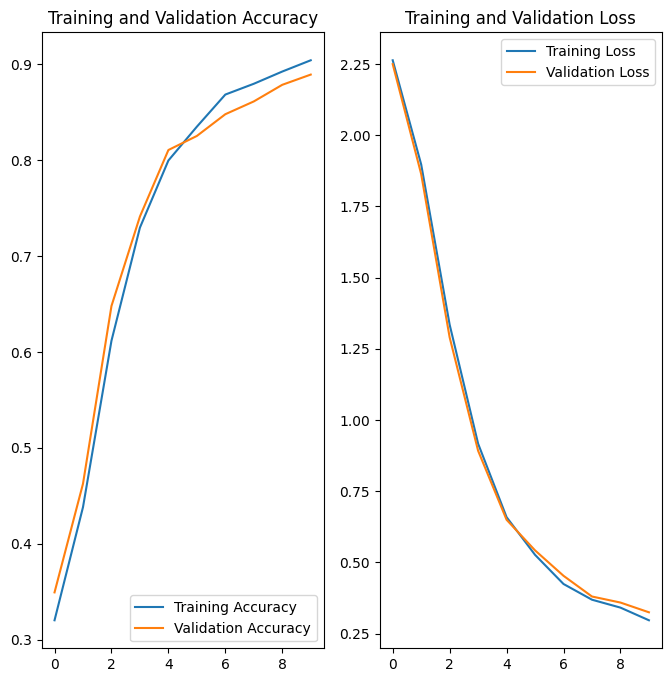

In [ ]:
# train_loss_array,train_acc_array,val_loss_array,val_acc_array
acc = train_acc_list
val_acc = test_acc_list

loss = train_loss_list
val_loss = test_loss_list
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model validation set prediction

In [ ]:
predict_list = []
label_list = []
predict_pro_list = []
m_softmax = nn.Softmax(dim=1)
for (img_rgb, y) in test_dataloader:
    img_rgb = img_rgb.to(device)
    y = y.to(device)

    predict_score = base_model_vgg13(img_rgb)
    predict_pro = m_softmax(predict_score)

    predict_label = np.argmax(predict_score.detach().cpu().numpy(),axis=1)

    predict_pro_list.append(predict_pro.detach().cpu().numpy())
    predict_list.append(predict_label)
    label_list.append(y.detach().cpu().numpy())

predict_pro_array = np.vstack(predict_pro_list)[:,1]
predict_array = np.hstack(predict_list)
label_array = np.hstack(label_list)
predict_pro_array[:5],predict_array[:5],label_array[:5]

(array([3.0368972e-03, 9.6516401e-01, 5.7121360e-04, 3.2337866e-06,
        3.5186354e-02], dtype=float32),
 array([4, 1, 3, 3, 2]),
 array([4, 1, 3, 3, 2]))

### Classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(label_array, predict_array,digits=3))

              precision    recall  f1-score   support

           0      0.667     0.392     0.494        51
           1      1.000     0.931     0.964        72
           2      0.952     0.930     0.941        43
           3      0.967     0.927     0.947        96
           4      0.741     0.909     0.816        22
           5      0.944     0.893     0.918        75
           6      0.791     0.922     0.851       115
           7      0.966     0.933     0.949        30
           8      0.768     0.973     0.859        75
           9      0.920     0.676     0.780        34
          10      0.959     1.000     0.979        70
          11      0.908     0.881     0.894        67

    accuracy                          0.883       750
   macro avg      0.882     0.864     0.866       750
weighted avg      0.885     0.883     0.878       750



### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(label_array, predict_array)
cnf_matrix

array([[ 20,   0,   0,   0,   3,   1,  27,   0,   0,   0,   0,   0],
       [  0,  67,   1,   0,   0,   0,   0,   0,   2,   0,   1,   1],
       [  0,   0,  40,   0,   0,   0,   0,   0,   1,   1,   1,   0],
       [  0,   0,   0,  89,   0,   0,   0,   0,   6,   1,   0,   0],
       [  1,   0,   0,   0,  20,   0,   1,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   4,  67,   0,   1,   0,   0,   0,   3],
       [  9,   0,   0,   0,   0,   0, 106,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  28,   0,   0,   0,   2],
       [  0,   0,   0,   2,   0,   0,   0,   0,  73,   0,   0,   0],
       [  0,   0,   0,   1,   0,   0,   0,   0,   9,  23,   1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  70,   0],
       [  0,   0,   1,   0,   0,   3,   0,   0,   4,   0,   0,  59]])

<Axes: >

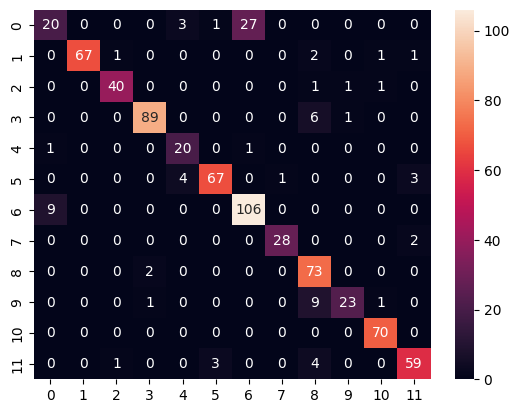

In [ ]:
sns.heatmap(cnf_matrix, annot=True, fmt='g')

# 11.Three models fusion efficientnet+resnet+swinTransformer

## Build the basic model vgg

In [ ]:

base_model_vgg13 = models.vgg13(pretrained=True)

base_model_vgg13.classifier[-1] = nn.Linear(4096, 100)

base_model_vgg13.to(device)(b_img_rgb.to(device)).shape



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG13_Weights.IMAGENET1K_V1`. You can also use `weights=VGG13_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg13-19584684.pth" to /root/.cache/torch/hub/checkpoints/vgg13-19584684.pth
100%|██████████| 508M/508M [00:03<00:00, 173MB/s]


torch.Size([8, 100])

## Build the basic model resnet18

In [ ]:

base_model_resnet18 = models.resnet18(pretrained=True)
num_ftrs = base_model_resnet18.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
base_model_resnet18.fc = nn.Linear(num_ftrs, 100)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


## Build the basic model transformer

In [ ]:

base_model_swin = models.swin_b(pretrained=True)

base_model_swin.head = nn.Linear(1024, 100)

base_model_swin.to(device)(b_img_rgb.to(device)).shape

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Swin_B_Weights.IMAGENET1K_V1`. You can also use `weights=Swin_B_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/swin_b-68c6b09e.pth" to /root/.cache/torch/hub/checkpoints/swin_b-68c6b09e.pth
100%|██████████| 335M/335M [00:01<00:00, 177MB/s]


torch.Size([8, 100])

## Merge to get the big model

In [ ]:
class ModeleBig(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model1 = base_model_resnet18
        self.base_model2 = base_model_vgg13
        self.base_model3 = base_model_swin

        encoder_layer = nn.TransformerEncoderLayer(d_model=100, nhead=2)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.fc1 = nn.Linear(300, 50)
        self.fc2 = nn.Linear(50, num_classes)
        self.flatten = nn.Flatten()


    def forward(self, img_rgb):
        # 模型一提取特征
        rgb_tensor1 = self.base_model1(img_rgb)

        # 模型二提取特征
        rgb_tensor2 = self.base_model2(img_rgb)

        # 模型三提取特征
        rgb_tensor3 = self.base_model3(img_rgb)

        # 合并特征
        x = torch.cat([rgb_tensor1,rgb_tensor2,rgb_tensor3],dim=1)

        x = self.fc1(x)
        x = self.fc2(x)
        return x

model_big = ModeleBig().to(device)
model_big(b_img_rgb.to(device)).shape

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([8, 12])

In [ ]:
model_big

ModeleBig(
  (base_model1): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

## Assignment loss function and optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss()

###Grid search method selects 'Adam', 'SGD', [1e-3, 1e-4, 1e-5] for experiment

In [ ]:
score_data = []
for opt, opt_name in zip([ torch.optim.Adam, torch.optim.SGD ], ['Adam', 'SGD']):
    for lr in [1e-3,1e-4, 1e-5]:
        model_big = ModeleBig().to(device)
        model_big(b_img_rgb.to(device)).shape
        optimizer = opt(model_big.parameters(), lr=lr)

        epochs = 2
        for t in range(epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            train(train_dataloader, model_big, loss_fn, optimizer)

            test(train_dataloader, model_big, loss_fn)
            test(test_dataloader, model_big, loss_fn)
        print("Done!")
        predict_list = []
        label_list = []
        predict_pro_list = []
        m_softmax = nn.Softmax(dim=1)
        for (img_rgb, y) in test_dataloader:
            img_rgb = img_rgb.to(device)
            y = y.to(device)

            predict_score = model_big(img_rgb)
            predict_pro = m_softmax(predict_score)

            predict_label = np.argmax(predict_score.detach().cpu().numpy(),axis=1)

            predict_pro_list.append(predict_pro.detach().cpu().numpy())
            predict_list.append(predict_label)
            label_list.append(y.detach().cpu().numpy())

        predict_pro_array = np.vstack(predict_pro_list)[:,1]
        predict_array = np.hstack(predict_list)
        label_array = np.hstack(label_list)

        acc = np.mean(predict_array == label_array)
        score_data.append([opt_name, lr, acc])

Epoch 1
-------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


loss: 2.891932  [    0/ 4000]
loss: 0.971148  [  400/ 4000]
loss: 1.267020  [  800/ 4000]
loss: 0.906495  [ 1200/ 4000]
loss: 1.106010  [ 1600/ 4000]
loss: 0.891751  [ 2000/ 4000]
loss: 0.418659  [ 2400/ 4000]
loss: 0.538471  [ 2800/ 4000]
loss: 0.483857  [ 3200/ 4000]
loss: 0.257939  [ 3600/ 4000]
Test Error: 
 Accuracy: 67.4%, Avg loss: 0.845058 

Test Error: 
 Accuracy: 69.5%, Avg loss: 0.857114 

Epoch 2
-------------------------------
loss: 0.684944  [    0/ 4000]
loss: 0.816980  [  400/ 4000]
loss: 1.000561  [  800/ 4000]
loss: 0.367183  [ 1200/ 4000]
loss: 0.267410  [ 1600/ 4000]
loss: 0.662517  [ 2000/ 4000]
loss: 1.330132  [ 2400/ 4000]
loss: 0.990282  [ 2800/ 4000]
loss: 1.633209  [ 3200/ 4000]
loss: 0.498918  [ 3600/ 4000]
Test Error: 
 Accuracy: 82.8%, Avg loss: 0.468825 

Test Error: 
 Accuracy: 78.3%, Avg loss: 0.611467 

Done!
Epoch 1
-------------------------------
loss: 2.653797  [    0/ 4000]
loss: 1.388410  [  400/ 4000]
loss: 1.294703  [  800/ 4000]
loss: 0.927779  

In [ ]:
score_df = pd.DataFrame(score_data, columns = ['optimizer', 'learning rate', 'Accuracy'])
score_df

,optimizer,learning rate,Accuracy
0,Adam,0.00100,0.766667
1,Adam,0.00010,0.898667
2,Adam,0.00001,0.864000
3,SGD,0.00100,0.905333
4,SGD,0.00010,0.858667
5,SGD,0.00001,0.413333


###Through quick experiments, select the configuration with the highest accuracy: SGD, 0.00100, then increase the number of training times, and set epochs = 10

## Fusion model training and evaluation

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_big.parameters(), lr=1e-3)

In [ ]:
epochs = 10
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model_big, loss_fn, optimizer)

    train_loss, train_correct = test(train_dataloader, model_big, loss_fn)
    test_loss, test_correct = test(test_dataloader, model_big, loss_fn)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_correct)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_correct)

print("Done!")

Epoch 1
-------------------------------
loss: 2.587858  [    0/ 4000]
loss: 2.356584  [  400/ 4000]
loss: 2.352222  [  800/ 4000]
loss: 2.415423  [ 1200/ 4000]
loss: 2.381101  [ 1600/ 4000]
loss: 2.337151  [ 2000/ 4000]
loss: 2.465839  [ 2400/ 4000]
loss: 2.250442  [ 2800/ 4000]
loss: 2.175980  [ 3200/ 4000]
loss: 2.357795  [ 3600/ 4000]
Test Error: 
 Accuracy: 39.4%, Avg loss: 1.902774 

Test Error: 
 Accuracy: 40.9%, Avg loss: 1.885551 

Epoch 2
-------------------------------
loss: 2.211263  [    0/ 4000]
loss: 1.847240  [  400/ 4000]
loss: 1.378726  [  800/ 4000]
loss: 1.900277  [ 1200/ 4000]
loss: 1.070981  [ 1600/ 4000]
loss: 1.149532  [ 2000/ 4000]
loss: 0.948814  [ 2400/ 4000]
loss: 0.762512  [ 2800/ 4000]
loss: 0.654037  [ 3200/ 4000]
loss: 0.473971  [ 3600/ 4000]
Test Error: 
 Accuracy: 83.3%, Avg loss: 0.509427 

Test Error: 
 Accuracy: 81.6%, Avg loss: 0.515842 

Epoch 3
-------------------------------
loss: 0.495806  [    0/ 4000]
loss: 0.878708  [  400/ 4000]
loss: 0.3535

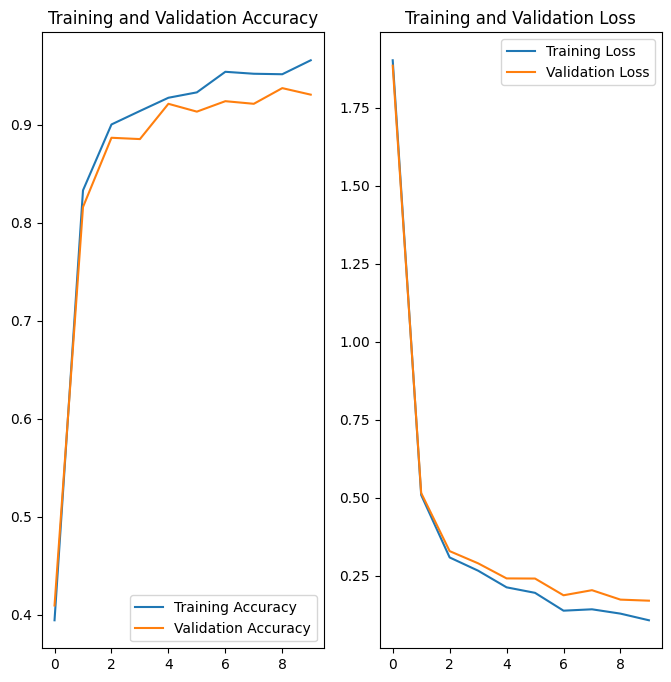

In [ ]:
# train_loss_array,train_acc_array,val_loss_array,val_acc_array
acc = train_acc_list
val_acc = test_acc_list

loss = train_loss_list
val_loss = test_loss_list
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
predict_list = []
label_list = []
predict_pro_list = []
m_softmax = nn.Softmax(dim=1)
# for image_batch, labels_batch in dataloaders['val']:
for (img_rgb, y) in test_dataloader:
    img_rgb = img_rgb.to(device)
    y = y.to(device)

    predict_score = model_big(img_rgb)
    predict_pro = m_softmax(predict_score)

    predict_label = np.argmax(predict_score.detach().cpu().numpy(),axis=1)

    predict_pro_list.append(predict_pro.detach().cpu().numpy())
    predict_list.append(predict_label)
    label_list.append(y.detach().cpu().numpy())

predict_pro_array = np.vstack(predict_pro_list)[:,1]
predict_array = np.hstack(predict_list)
label_array = np.hstack(label_list)
predict_pro_array[:5],predict_array[:5],label_array[:5]

(array([4.6217367e-05, 9.9972409e-01, 1.0265945e-04, 2.2984362e-07,
        6.1711698e-04], dtype=float32),
 array([4, 1, 3, 3, 2]),
 array([4, 1, 3, 3, 2]))

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(label_array, predict_array,digits=3))

              precision    recall  f1-score   support

           0      0.769     0.588     0.667        51
           1      0.986     0.986     0.986        72
           2      0.894     0.977     0.933        43
           3      0.959     0.979     0.969        96
           4      0.950     0.864     0.905        22
           5      0.986     0.960     0.973        75
           6      0.843     0.930     0.884       115
           7      1.000     1.000     1.000        30
           8      0.923     0.960     0.941        75
           9      1.000     0.912     0.954        34
          10      1.000     1.000     1.000        70
          11      0.969     0.940     0.955        67

    accuracy                          0.935       750
   macro avg      0.940     0.925     0.931       750
weighted avg      0.934     0.935     0.933       750



In [ ]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(label_array, predict_array)
cnf_matrix

array([[ 30,   0,   0,   0,   1,   0,  20,   0,   0,   0,   0,   0],
       [  0,  71,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   1,  42,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,  94,   0,   0,   0,   0,   2,   0,   0,   0],
       [  1,   0,   1,   0,  19,   1,   0,   0,   0,   0,   0,   0],
       [  0,   0,   1,   0,   0,  72,   0,   0,   0,   0,   0,   2],
       [  8,   0,   0,   0,   0,   0, 107,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  30,   0,   0,   0,   0],
       [  0,   0,   0,   3,   0,   0,   0,   0,  72,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   3,  31,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  70,   0],
       [  0,   0,   2,   1,   0,   0,   0,   0,   1,   0,   0,  63]])

<Axes: >

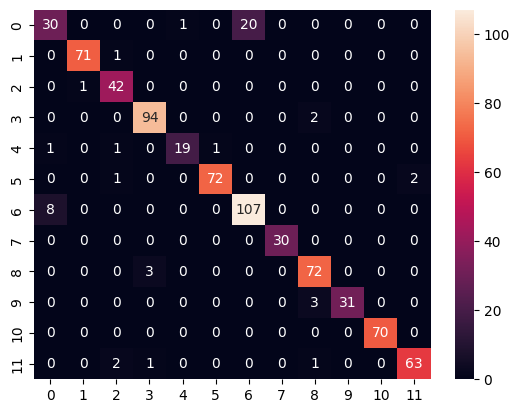

In [ ]:
sns.heatmap(cnf_matrix, annot=True, fmt='g')

# 12.Fusion model parameter tuning

## Integrate model training and parameter tuning-add attention mechanism

In [ ]:
class ModeleBig(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model1 = base_model_resnet18
        self.base_model2 = base_model_vgg13
        self.base_model3 = base_model_swin

        self.att = nn.TransformerEncoderLayer(d_model=100, nhead=2)
        self.fc1 = nn.Linear(300, 50)
        self.fc2 = nn.Linear(50, num_classes)
        self.flatten = nn.Flatten()



    def forward(self, img_rgb):
        # 模型一提取特征
        rgb_tensor1 = self.base_model1(img_rgb)

        # 模型二提取特征
        rgb_tensor2 = self.base_model2(img_rgb)

        # 模型三提取特征
        rgb_tensor3 = self.base_model3(img_rgb)

        # 合并特征
        x = torch.stack([rgb_tensor1,rgb_tensor2,rgb_tensor3],dim=1)
        x = self.att(x)
        x = self.flatten(x)


        x = self.fc1(x)
        x = self.fc2(x)
        return x

model_big = ModeleBig().to(device)
model_big(b_img_rgb.to(device)).shape

torch.Size([8, 12])

In [ ]:
model_big

ModeleBig(
  (base_model1): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_big.parameters(), lr=1e-3)

In [ ]:
epochs = 10
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model_big, loss_fn, optimizer)

    train_loss, train_correct = test(train_dataloader, model_big, loss_fn)
    test_loss, test_correct = test(test_dataloader, model_big, loss_fn)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_correct)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_correct)

print("Done!")

Epoch 1
-------------------------------
loss: 1.870776  [    0/ 4000]
loss: 1.557274  [  400/ 4000]
loss: 2.024384  [  800/ 4000]
loss: 1.199900  [ 1200/ 4000]
loss: 1.287655  [ 1600/ 4000]
loss: 1.316129  [ 2000/ 4000]
loss: 1.088008  [ 2400/ 4000]
loss: 1.224002  [ 2800/ 4000]
loss: 0.884759  [ 3200/ 4000]
loss: 0.905806  [ 3600/ 4000]
Test Error: 
 Accuracy: 81.1%, Avg loss: 0.706986 

Test Error: 
 Accuracy: 80.1%, Avg loss: 0.690805 

Epoch 2
-------------------------------
loss: 0.918142  [    0/ 4000]
loss: 1.158186  [  400/ 4000]
loss: 0.600152  [  800/ 4000]
loss: 0.592020  [ 1200/ 4000]
loss: 0.721469  [ 1600/ 4000]
loss: 0.682835  [ 2000/ 4000]
loss: 0.756482  [ 2400/ 4000]
loss: 0.802038  [ 2800/ 4000]
loss: 0.479086  [ 3200/ 4000]
loss: 0.667588  [ 3600/ 4000]
Test Error: 
 Accuracy: 88.7%, Avg loss: 0.450078 

Test Error: 
 Accuracy: 86.7%, Avg loss: 0.454737 

Epoch 3
-------------------------------
loss: 0.432666  [    0/ 4000]
loss: 0.653663  [  400/ 4000]
loss: 0.6402

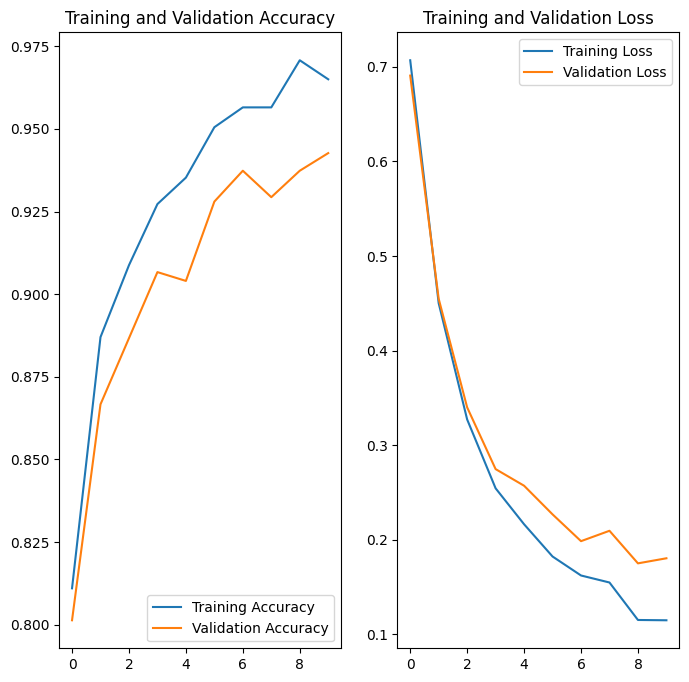

In [ ]:
# train_loss_array,train_acc_array,val_loss_array,val_acc_array
acc = train_acc_list
val_acc = test_acc_list

loss = train_loss_list
val_loss = test_loss_list
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
predict_list = []
label_list = []
predict_pro_list = []
m_softmax = nn.Softmax(dim=1)
# for image_batch, labels_batch in dataloaders['val']:
for (img_rgb, y) in test_dataloader:
    img_rgb = img_rgb.to(device)
    y = y.to(device)

    predict_score = model_big(img_rgb)
    predict_pro = m_softmax(predict_score)

    predict_label = np.argmax(predict_score.detach().cpu().numpy(),axis=1)

    predict_pro_list.append(predict_pro.detach().cpu().numpy())
    predict_list.append(predict_label)
    label_list.append(y.detach().cpu().numpy())

predict_pro_array = np.vstack(predict_pro_list)[:,1]
predict_array = np.hstack(predict_list)
label_array = np.hstack(label_list)
predict_pro_array[:5],predict_array[:5],label_array[:5]

(array([9.5701101e-04, 9.9637407e-01, 1.2604627e-05, 8.3620125e-06,
        1.8136880e-03], dtype=float32),
 array([4, 1, 3, 3, 2]),
 array([4, 1, 3, 3, 2]))

### Classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(label_array, predict_array,digits=3))

              precision    recall  f1-score   support

           0      0.882     0.588     0.706        51
           1      0.986     0.986     0.986        72
           2      0.977     0.977     0.977        43
           3      0.979     0.979     0.979        96
           4      1.000     0.909     0.952        22
           5      0.974     0.987     0.980        75
           6      0.848     0.974     0.907       115
           7      1.000     1.000     1.000        30
           8      0.892     0.987     0.937        75
           9      0.963     0.765     0.852        34
          10      1.000     1.000     1.000        70
          11      0.970     0.970     0.970        67

    accuracy                          0.944       750
   macro avg      0.956     0.927     0.937       750
weighted avg      0.946     0.944     0.941       750



### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(label_array, predict_array)
cnf_matrix

array([[ 30,   0,   0,   0,   0,   1,  20,   0,   0,   0,   0,   0],
       [  0,  71,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0],
       [  0,   1,  42,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,  94,   0,   0,   0,   0,   1,   1,   0,   0],
       [  1,   0,   0,   0,  20,   0,   0,   0,   0,   0,   0,   1],
       [  0,   0,   0,   0,   0,  74,   0,   0,   0,   0,   0,   1],
       [  3,   0,   0,   0,   0,   0, 112,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  30,   0,   0,   0,   0],
       [  0,   0,   0,   1,   0,   0,   0,   0,  74,   0,   0,   0],
       [  0,   0,   0,   1,   0,   0,   0,   0,   7,  26,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  70,   0],
       [  0,   0,   1,   0,   0,   0,   0,   0,   1,   0,   0,  65]])

<Axes: >

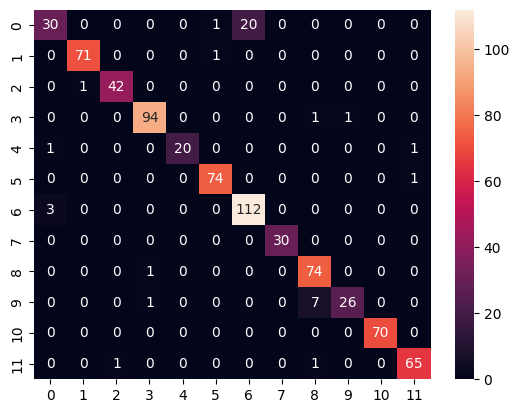

In [ ]:
sns.heatmap(cnf_matrix, annot=True, fmt='g')

## Integrate model training and parameter tuning-modify MLP and other hyperparameters

In [ ]:
# Loss with L1 regularization
def l1_regularized_loss(output, target, model, base_loss_fn, lambda_l1=1e-5):
    cross_entropy = base_loss_fn(output, target)
    l1 = torch.tensor(0.).to(device)
    for name, param in model.named_parameters():
        if 'weight' in name:
            l1 += torch.norm(param, 1)
    return cross_entropy + lambda_l1 * l1

base_loss_fn = nn.CrossEntropyLoss()


In [ ]:
class ModeleBig(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model1 = base_model_resnet18
        self.base_model2 = base_model_vgg13
        self.base_model3 = base_model_swin

        self.fc1 = nn.Linear(300, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.4)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.4)

        self.fc_res = nn.Linear(300, 128)  # Residual connection
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, img_rgb):
        rgb_tensor1 = self.base_model1(img_rgb)
        rgb_tensor2 = self.base_model2(img_rgb)
        rgb_tensor3 = self.base_model3(img_rgb)
        x = torch.cat([rgb_tensor1, rgb_tensor2, rgb_tensor3], dim=1)
        x1 = F.relu(self.bn1(self.fc1(x)))
        x1 = self.dropout1(x1)
        x1 = F.relu(self.bn2(self.fc2(x1)))
        x1 = self.dropout2(x1)
        x_res = self.fc_res(x)
        x_final = x1 + x_res
        x_final = self.fc3(x_final)
        return x_final

model_big = ModeleBig().to(device)


In [ ]:
optimizer = torch.optim.SGD(model_big.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

In [ ]:
epochs = 10
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model_big, loss_fn, optimizer)

    train_loss, train_correct = test(train_dataloader, model_big, loss_fn)
    test_loss, test_correct = test(test_dataloader, model_big, loss_fn)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_correct)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_correct)

print("Done!")

Epoch 1
-------------------------------
loss: 2.750451  [    0/ 4000]
loss: 2.372637  [  400/ 4000]
loss: 2.202001  [  800/ 4000]
loss: 1.851388  [ 1200/ 4000]
loss: 1.333205  [ 1600/ 4000]
loss: 1.044970  [ 2000/ 4000]
loss: 1.055358  [ 2400/ 4000]
loss: 0.598280  [ 2800/ 4000]
loss: 1.421106  [ 3200/ 4000]
loss: 0.411287  [ 3600/ 4000]
Test Error: 
 Accuracy: 83.0%, Avg loss: 0.450681 

Test Error: 
 Accuracy: 82.0%, Avg loss: 0.469133 

Epoch 2
-------------------------------
loss: 0.695952  [    0/ 4000]
loss: 0.320798  [  400/ 4000]
loss: 1.165456  [  800/ 4000]
loss: 0.840704  [ 1200/ 4000]
loss: 0.343588  [ 1600/ 4000]
loss: 0.393045  [ 2000/ 4000]
loss: 1.498680  [ 2400/ 4000]
loss: 0.427953  [ 2800/ 4000]
loss: 0.553365  [ 3200/ 4000]
loss: 0.967953  [ 3600/ 4000]
Test Error: 
 Accuracy: 91.1%, Avg loss: 0.236712 

Test Error: 
 Accuracy: 90.1%, Avg loss: 0.280021 

Epoch 3
-------------------------------
loss: 0.432510  [    0/ 4000]
loss: 0.325787  [  400/ 4000]
loss: 0.2255

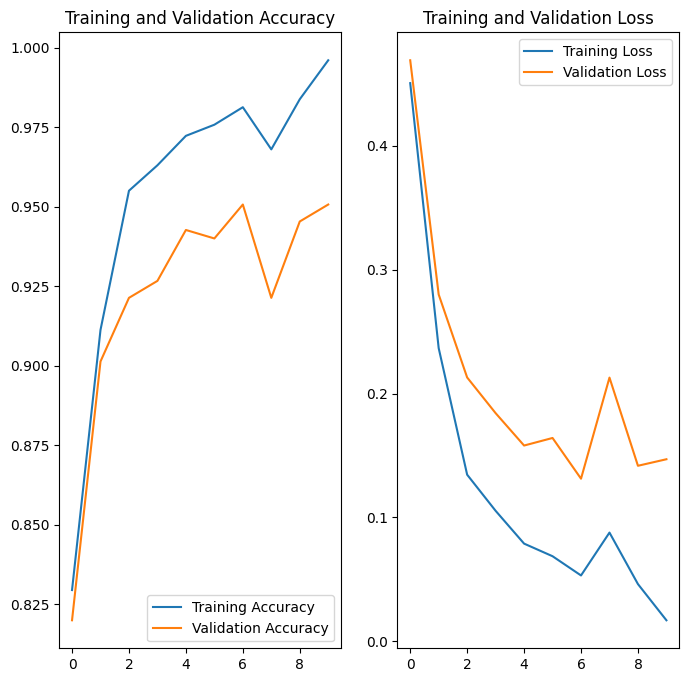

In [ ]:
# train_loss_array,train_acc_array,val_loss_array,val_acc_array
acc = train_acc_list
val_acc = test_acc_list

loss = train_loss_list
val_loss = test_loss_list
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
predict_list = []
label_list = []
predict_pro_list = []
m_softmax = nn.Softmax(dim=1)
# for image_batch, labels_batch in dataloaders['val']:
for (img_rgb, y) in test_dataloader:
    img_rgb = img_rgb.to(device)
    y = y.to(device)

    predict_score = model_big(img_rgb)
    predict_pro = m_softmax(predict_score)

    predict_label = np.argmax(predict_score.detach().cpu().numpy(),axis=1)

    predict_pro_list.append(predict_pro.detach().cpu().numpy())
    predict_list.append(predict_label)
    label_list.append(y.detach().cpu().numpy())

predict_pro_array = np.vstack(predict_pro_list)[:,1]
predict_array = np.hstack(predict_list)
label_array = np.hstack(label_list)
predict_pro_array[:5],predict_array[:5],label_array[:5]

(array([6.4403730e-07, 1.0000000e+00, 1.0872149e-05, 4.4283387e-13,
        6.1562895e-07], dtype=float32),
 array([4, 1, 3, 3, 2]),
 array([4, 1, 3, 3, 2]))

### Classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(label_array, predict_array,digits=3))

              precision    recall  f1-score   support

           0      0.897     0.686     0.778        51
           1      0.973     0.986     0.979        72
           2      1.000     0.930     0.964        43
           3      0.969     0.979     0.974        96
           4      0.846     1.000     0.917        22
           5      0.987     0.987     0.987        75
           6      0.888     0.965     0.925       115
           7      1.000     1.000     1.000        30
           8      0.986     0.973     0.980        75
           9      1.000     1.000     1.000        34
          10      1.000     1.000     1.000        70
          11      0.970     0.970     0.970        67

    accuracy                          0.959       750
   macro avg      0.960     0.956     0.956       750
weighted avg      0.959     0.959     0.958       750



### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(label_array, predict_array)
cnf_matrix

array([[ 35,   0,   0,   0,   2,   0,  14,   0,   0,   0,   0,   0],
       [  0,  71,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0],
       [  0,   2,  40,   0,   0,   0,   0,   0,   0,   0,   0,   1],
       [  0,   0,   0,  94,   0,   0,   0,   0,   1,   0,   0,   1],
       [  0,   0,   0,   0,  22,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   1,  74,   0,   0,   0,   0,   0,   0],
       [  4,   0,   0,   0,   0,   0, 111,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  30,   0,   0,   0,   0],
       [  0,   0,   0,   2,   0,   0,   0,   0,  73,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  34,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  70,   0],
       [  0,   0,   0,   1,   1,   0,   0,   0,   0,   0,   0,  65]])

<Axes: >

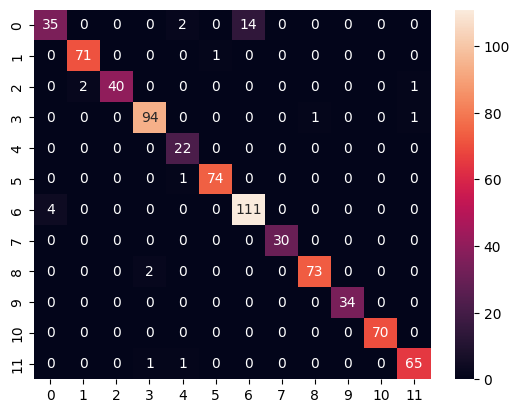

In [ ]:
sns.heatmap(cnf_matrix, annot=True, fmt='g')